In [1]:
# Libraries
import tensorflow
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, ConcatDataset
from transformers import AutoTokenizer, BertTokenizer 

import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sn
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from ABSA_SentimentMultiEmiten.model.bert import bert_ABSA
from ABSA_SentimentMultiEmiten.data.dataset import dataset_ABSA

2023-06-19 17:56:49.057399: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# Menentukan device yang akan digunakan untuk melakukan komputasi
DEVICE = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

print("Tensorflow\t: ", tensorflow.__version__)
print("Torch\t\t: ", torch.__version__)
print("Device\t\t: ", DEVICE)
print("GPU\t\t: ", torch.cuda.get_device_name())
print("CUDA\t\t: ", torch.version.cuda)

Tensorflow	:  2.4.1
Torch		:  1.1.0
Device		:  cuda:3
GPU		:  Tesla T4
CUDA		:  9.0.176


In [3]:
# Hyperparameter
bs = 16
lr = 0.00002

In [4]:
# Inisialisasi pre-trained model IndoBERT
### IndoLEM
pretrained_model_name = "indolem/indobert-base-uncased"
model_name = "indolem-indobert-gs/indolem-indobert-gs-1.pkl"

### IndoNLU
#pretrained_model_name = "indobenchmark/indobert-base-p1"
## Skenario 1.2
#model_name = "indonlu-indobert-gs/indonlu-indobert-gs-1.pkl"
## Skenario 1.3
#model_name = "indonlu-indobert-gs/indonlu-indobert-gs-2.pkl"

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)
model_ABSA = bert_ABSA(pretrained_model_name)
model_ABSA.to(DEVICE)
optimizer_ABSA = torch.optim.Adam(model_ABSA.parameters(), lr=lr)

In [5]:
# Function untuk load model
def load_model(model, path):
    model.load_state_dict(torch.load(path), strict=False)
    return model

In [6]:
# Mengubah dataset menjadi beberapa mini-batch
def create_mini_batch(samples):
    ids_tensors = [s[1] for s in samples]
    ids_tensors = pad_sequence(ids_tensors, batch_first=True)

    segments_tensors = [s[2] for s in samples]
    segments_tensors = pad_sequence(segments_tensors, batch_first=True)

    label_ids = torch.stack([s[3] for s in samples])
    
    masks_tensors = torch.zeros(ids_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(ids_tensors != 0, 1)

    return ids_tensors, segments_tensors, masks_tensors, label_ids

In [7]:
# Function untuk pengujian model
def test_model_ABSA(loader):
    pred = []
    truth = []
    
    with torch.no_grad():
        # Pengulangan setiap mini-batch
        for data in loader:
            ids_tensors, segments_tensors, masks_tensors, label_ids = data
            ids_tensors = ids_tensors.to(DEVICE)
            segments_tensors = segments_tensors.to(DEVICE)
            masks_tensors = masks_tensors.to(DEVICE)

            outputs = model_ABSA(ids_tensors, None, masks_tensors=masks_tensors, segments_tensors=segments_tensors)
            
            _, predictions = torch.max(outputs, dim=1)

            pred += list([int(i) for i in predictions])
            truth += list([int(i) for i in label_ids])

    return truth, pred

In [8]:
# Function untuk menampilkan confusion matrix
def draw_c_matrix(c_matrix, title="test"):
    aix = []
    
    for y in range(len(c_matrix)):
        aix.append(y)
    df_cm = pd.DataFrame(c_matrix, aix, aix)
    sn.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
    plt.ylabel("ground truth")
    plt.xlabel("prediction")
    plt.title(title)
    plt.show()

In [9]:
# Inisialisasi dataset
emiten_test_ds = dataset_ABSA(pd.read_csv("data_experiment/data_balance_experiment_testing.csv"), tokenizer)
test_ds = ConcatDataset([emiten_test_ds])

# Mengubah dataset menjadi mini-batch
test_loader = DataLoader(test_ds, batch_size=bs, collate_fn=create_mini_batch, shuffle = True)

In [10]:
model_ABSA = load_model(model_ABSA, model_name)

In [11]:
# Classification report
x, y = test_model_ABSA(test_loader)
print(classification_report(x, y, target_names=[str(i) for i in range(3)]))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       806
           1       0.88      0.90      0.89       808
           2       0.90      0.89      0.90       799

    accuracy                           0.92      2413
   macro avg       0.92      0.92      0.92      2413
weighted avg       0.92      0.92      0.92      2413



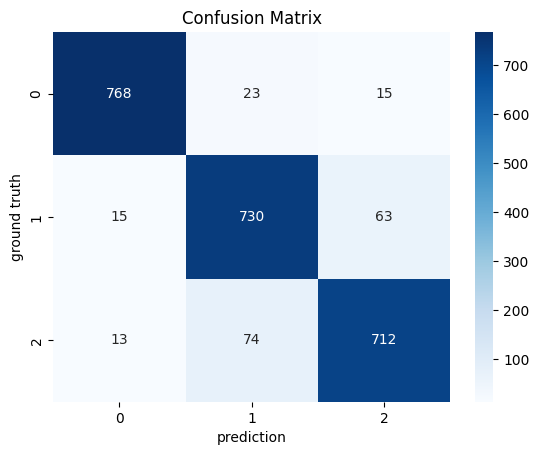

In [12]:
cf_matrix = confusion_matrix(x, y)
draw_c_matrix(cf_matrix, title="Confusion Matrix")